Deconvolution Microscopy (Single Channel)
=========================================

This example partially replicates a [GlobalBioIm
example](https://biomedical-imaging-group.github.io/GlobalBioIm/examples.html)
using the [microscopy data](http://bigwww.epfl.ch/deconvolution/bio/)
provided by the EPFL Biomedical Imaging Group.

The deconvolution problem is solved using class
[admm.ADMM](../_autosummary/scico.optimize.rst#scico.optimize.ADMM) to
solve an image deconvolution problem with isotropic total variation (TV)
regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; \| M (\mathbf{y} - A \mathbf{x})
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} +
  \iota_{\mathrm{NN}}(\mathbf{x}) \;,$$

where $M$ is a mask operator, $A$ is circular convolution,
$\mathbf{y}$ is the blurred image, $C$ is a convolutional gradient
operator, $\iota_{\mathrm{NN}}$ is the indicator function of the
non-negativity constraint, and $\mathbf{x}$ is the desired image.

In [1]:
import glob
import os
import tempfile
import zipfile

import numpy as np

import imageio

import scico.numpy as snp
from scico import functional, linop, loss, plot, util
from scico.optimize.admm import ADMM, CircularConvolveSolver
plot.config_notebook_plotting()

Define helper functions.

In [2]:
def volume_read(path, ext="tif"):
    """Read a 3D volume from a set of files in the specified directory."""

    slices = []
    for file in sorted(glob.glob(os.path.join(path, "*." + ext))):
        image = imageio.imread(file)
        slices.append(image)
    return np.dstack(slices)


def get_deconv_data(channel, cache_path=None):
    """Get deconvolution problem data from EPFL Biomedical Imaging Group."""

    # data source URL and filenames
    data_base_url = "http://bigwww.epfl.ch/deconvolution/bio/"
    data_zip_files = ["CElegans-CY3.zip", "CElegans-DAPI.zip", "CElegans-FITC.zip"]
    psf_zip_files = ["PSF-" + data for data in data_zip_files]
    # set default cache path if not specified
    if cache_path is None:
        cache_path = os.path.join(os.path.expanduser("~"), ".cache", "scico", "epfl_big")

    # if cache path exists, data is assumed to aleady be downloaded
    if not os.path.isdir(os.path.join(cache_path, data_zip_files[channel][:-4])):
        if not os.path.isdir(cache_path):
            os.makedirs(cache_path)
        # temporary directory for downloads
        temp_dir = tempfile.TemporaryDirectory()
        # download data and psf files for selected channel into temporary directory
        for zip_file in (data_zip_files[channel], psf_zip_files[channel]):
            data = util.url_get(data_base_url + zip_file)
            f = open(os.path.join(temp_dir.name, zip_file), "wb")
            f.write(data.read())
            f.close()
        # unzip downloaded data into cache path
        for zip_file in (data_zip_files[channel], psf_zip_files[channel]):
            with zipfile.ZipFile(os.path.join(temp_dir.name, zip_file), "r") as zip_ref:
                zip_ref.extractall(cache_path)

    # read unzipped data files into 3D arrays
    zip_file = data_zip_files[channel]
    y = volume_read(os.path.join(cache_path, zip_file[:-4])).astype(np.float32)
    zip_file = psf_zip_files[channel]
    psf = volume_read(os.path.join(cache_path, zip_file[:-4])).astype(np.float32)
    return y, psf


def block_avg(im, N):
    """Average distinct NxNxN blocks of im, return the resulting smaller image."""

    im = snp.mean(snp.reshape(im, (-1, N, im.shape[1], im.shape[2])), axis=1)
    im = snp.mean(snp.reshape(im, (im.shape[0], -1, N, im.shape[2])), axis=2)
    im = snp.mean(snp.reshape(im, (im.shape[0], im.shape[1], -1, N)), axis=3)

    return im

Get and preprocess data. We downsample by a factor of 4 for purposes of
the example. Reducing the downsampling rate will be slower and more
memory-intensive. If your GPU does not have enough memory, you can try
setting the environment variable `JAX_PLATFORM_NAME=cpu` to run on CPU.

In [3]:
channel = 0
downsampling_rate = 4

y, psf = get_deconv_data(channel)
y = block_avg(y, downsampling_rate)
psf = block_avg(psf, downsampling_rate)

y -= y.min()
y /= y.max()

psf /= psf.sum()

Pad data and create mask.

In [4]:
padding = [[0, p] for p in snp.array(psf.shape) - 1]
y_pad = snp.pad(y, padding)
mask = snp.pad(snp.ones_like(y), padding)

Define problem and algorithm parameters.

In [5]:
λ = 2e-6  # ℓ1 norm regularization parameter
ρ0 = 1e-3  # ADMM penalty parameter for first auxiliary variable
ρ1 = 1e-3  # ADMM penalty parameter for second auxiliary variable
ρ2 = 1e-3  # ADMM penalty parameter for third auxiliary variable
maxiter = 100  # number of ADMM iterations

Create operators.

In [6]:
M = linop.Diagonal(mask)
C0 = linop.CircularConvolve(h=psf, input_shape=mask.shape, h_center=snp.array(psf.shape) / 2 - 0.5)
C1 = linop.FiniteDifference(input_shape=mask.shape, circular=True)
C2 = linop.Identity(mask.shape)

Create functionals.

In [7]:
g0 = loss.SquaredL2Loss(y=y_pad, A=M)  # loss function (forward model)
g1 = λ * functional.L21Norm()  # TV penalty (when applied to gradient)
g2 = functional.NonNegativeIndicator()  # non-negativity constraint

Set up ADMM solver object and solve problem.

In [8]:
solver = ADMM(
    f=None,
    g_list=[g0, g1, g2],
    C_list=[C0, C1, C2],
    rho_list=[ρ0, ρ1, ρ2],
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
    x0=y_pad,
    subproblem_solver=CircularConvolveSolver(),
)

print("Solving on %s\n" % util.device_info())
solver.solve()
solve_stats = solver.itstat_object.history(transpose=True)
x_pad = solver.x
x = x_pad[: y.shape[0], : y.shape[1], : y.shape[2]]

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  2.41e+00  6.897e-02  1.059e+02  7.430e+01


  10  4.43e+00  2.219e-01  2.021e+01  3.712e+01


  20  4.88e+00  2.419e-01  2.942e+01  1.812e+01


  30  5.33e+00  2.470e-01  1.580e+01  2.253e+01


  40  5.77e+00  2.861e-01  1.935e+01  1.260e+01


  50  6.26e+00  3.150e-01  1.252e+01  1.554e+01


  60  6.69e+00  3.409e-01  1.403e+01  1.115e+01


  70  7.11e+00  3.740e-01  1.032e+01  1.179e+01


  80  7.59e+00  3.988e-01  1.012e+01  9.620e+00


  90  8.01e+00  4.282e-01  8.070e+00  9.803e+00


  99  8.41e+00  4.550e-01  8.431e+00  8.293e+00


Show the recovered image.

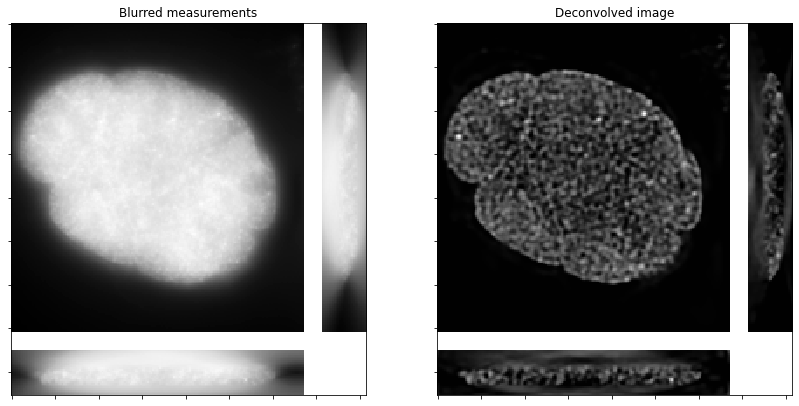

In [9]:
def make_slices(x, sep_width=10):
    """Make an image with xy, xz, and yz slices from an input volume."""

    fill_val = -1.0
    out = snp.concatenate(
        (
            x[:, :, x.shape[2] // 2],
            snp.full((x.shape[0], sep_width), fill_val),
            x[:, x.shape[1] // 2, :],
        ),
        axis=1,
    )

    out = snp.concatenate(
        (
            out,
            snp.full((sep_width, out.shape[1]), fill_val),
            snp.concatenate(
                (
                    x[x.shape[0] // 2, :, :].T,
                    snp.full((x.shape[2], x.shape[2] + sep_width), fill_val),
                ),
                axis=1,
            ),
        ),
        axis=0,
    )

    out = snp.where(out == fill_val, out.max(), out)

    return out


fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot.imview(make_slices(y), title="Blurred measurements", fig=fig, ax=ax[0])
plot.imview(make_slices(x), title="Deconvolved image", fig=fig, ax=ax[1])
fig.show()

Plot convergence statistics.

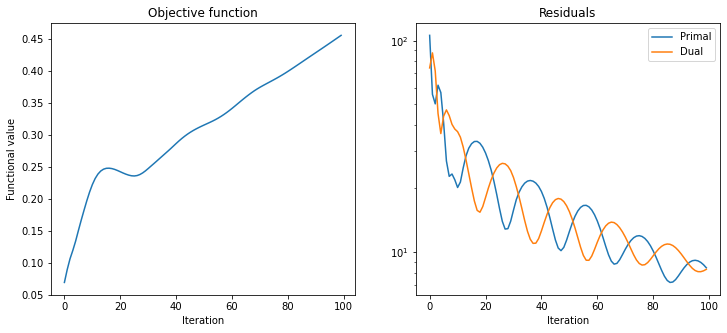

In [10]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    solve_stats.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((solve_stats.Prml_Rsdl, solve_stats.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()